## Imports and database connection

In [1]:
# Database Interaction
import pandas as pd
import requests
from sqlalchemy import *
import datetime

# Analytics packages
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics

from scipy.stats import beta
from scipy.stats import poisson

from pull_from_database import *

%matplotlib inline

## Split dataframe into last 24 hours and prior

cutoff_time = datetime.datetime.fromtimestamp(df['created_time'].max())-datetime.timedelta(hours = 24)
last_day_df = df[df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)) > cutoff_time].reset_index()
train_df = df[df['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x)) <= cutoff_time].reset_index()
#train_df['cluster_label_2'] = '' #add empty column for sub cluster label

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days


## First pass spatial clustering with DBSCAN

In [2]:
Xtrain = np.vstack((train_df.longitude, train_df.lat)).T
Xtrain *= np.pi/180

# Compute DBSCAN
db = DBSCAN(eps=2e-4,         #4e-5
            min_samples=5,
            metric='haversine'
           ).fit(Xtrain)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = list(db.labels_)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

train_df['cluster_label'] = pd.Series(labels)

Estimated number of clusters: 819


## Compute Cluster Radii

In [3]:
# This is actually an upper bound on the set radius
from geopy.distance import vincenty

# Filter spatial outliers
cluster_df = train_df[train_df['cluster_label'] != -1]

# Find cluster centroids in (lat, long) space
cluster_centroids = cluster_df[['cluster_label','lat','longitude']].groupby(['cluster_label']).mean().reset_index()
cluster_point_centroids = pd.merge(left = cluster_df[['cluster_label','lat','longitude']], right = cluster_centroids, how = 'inner', on = 'cluster_label', suffixes = ('_point','_centroid')).reset_index()

# Distance measure
def dist(x1,x2,y1,y2):
    #print x1, x2, y1, y2
    if sum(np.isnan([x1,x2,y1,y2])):
        return 0;
    else:
        return vincenty((x1,x2),(y1,y2)).miles

# Calculate distance of each point from centroid
cluster_point_centroids['distance_from_centroid'] = cluster_point_centroids.apply(lambda x: dist(x['lat_point'], x['longitude_point'], x['lat_centroid'], x['longitude_centroid']),axis = 1)

# Max over all distances from centroid
cluster_radius = cluster_point_centroids.groupby('cluster_label').max().reset_index()
cluster_radius = cluster_radius[['cluster_label','lat_centroid','longitude_centroid','distance_from_centroid']]

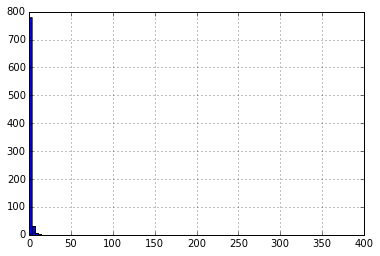

In [4]:
cluster_radius['distance_from_centroid'].hist(bins = 100)

In [5]:
def run_KMeans(n_clusters, sub_cluster):

    Xtrain = np.vstack((sub_cluster.longitude, sub_cluster.lat)).T
    Xtrain *= np.pi/180

    # Compute KMeans
    km = KMeans(
                n_clusters = n_clusters, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                tol=0.0001, 
                precompute_distances='auto', 
                verbose=0, 
                random_state=None, 
                copy_x=True, 
                n_jobs=1
               ).fit(Xtrain)


    labels = list(km.labels_)

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    sub_cluster = sub_cluster.reset_index()
    #print sub_cluster

    sub_cluster['cluster_label_2'] = pd.Series(labels)
    #sub_cluster['cluster_label_2'] = sub_cluster.apply(lambda x: -1 if np.isnan(x) else x) #<-------------------

    # Attach centroid coordinates to each element
    clus_cent = km.cluster_centers_ * 180 /np.pi
    sub_cluster_centroid = pd.DataFrame(np.hstack((np.arange(n_clusters).reshape(n_clusters,1),clus_cent)), columns = ['cluster_label_2','longitude_centroid','lat_centroid'])
    sub_cluster1 = pd.merge(sub_cluster, sub_cluster_centroid, how = 'left', on = 'cluster_label_2')

    # Calculate distance of each point from centroid
    sub_cluster1['distance_from_centroid'] = sub_cluster1.apply(lambda x: dist(x['lat'], x['longitude'], x['lat_centroid'], x['longitude_centroid']),axis = 1)

    # Max over all distances from centroid
    sub_cluster_radius = sub_cluster1.groupby('cluster_label_2').max().reset_index()
    #sub_cluster_radius = sub_cluster_radius[['cluster_label_2','lat_centroid','longitude_centroid','distance_from_centroid']]

    return np.median(sub_cluster_radius['distance_from_centroid'].values), labels, sub_cluster

In [6]:
large_clusters = cluster_radius[cluster_radius['distance_from_centroid'] > 8]['cluster_label'].values

mod_sub_clusters = []
for large_cluster in large_clusters:
    print 'Subdividing cluster %d' % large_cluster 
    sub_cluster = train_df[train_df['cluster_label'] == large_cluster]
    #print len(sub_cluster)

    ## Compute cluster
    threshhold = 1 # miles
    top_value = 40
    bot_value = 1
    out = threshhold + 1

    print 'Defining search space'
    max_iter_expand_search = 10
    
    expand_search_count = 0
    # expand search space
    while (out > threshhold) and (expand_search_count <= max_iter_expand_search):
        out, labels, mod_sub_cluster = run_KMeans(top_value, sub_cluster)
        if out > threshhold:
            bot_value = top_value
            top_value *= 10
            top_value = min([top_value,100])
        expand_search_count += 1

    #print top_value, bot_value

    print 'Backtracking!'
    # binary search (backtrace)
    while top_value - bot_value > 1:
        probe = int(round(np.mean([top_value, bot_value])))
        out, labels, mod_sub_cluster = run_KMeans(probe, sub_cluster)
        if out > threshhold:
            bot_value = probe
        else:
            top_value = probe
    
    #print len(mod_sub_cluster)
    #print mod_sub_cluster['cluster_label_2']
    mod_sub_clusters.append(mod_sub_cluster)
    print out, probe
    
mod_sub_clusters1 = pd.concat(mod_sub_clusters)[['index','cluster_label_2']]


mod_sub_clusters1['cluster_label_2'] = mod_sub_clusters1.apply(lambda x: -1 if np.isnan(x['cluster_label_2']) else x['cluster_label_2'], axis = 1)

train_df1 = pd.merge(train_df, mod_sub_clusters1, how = 'left', on = 'index')

Subdividing cluster 13
Defining search space
Backtracking!
1.02017302578 33
Subdividing cluster 33
Defining search space
Backtracking!
1.27066576042 10
Subdividing cluster 35
Defining search space
Backtracking!
1.06653495293 7
Subdividing cluster 67
Defining search space
Backtracking!
0.942477131639 7
Subdividing cluster 74
Defining search space
Backtracking!
1.03399068518 47
Subdividing cluster 75
Defining search space
Backtracking!
1.01214758442 15
Subdividing cluster 142
Defining search space
Backtracking!
2.60151969493 2


In [7]:
def calc_subcluster_stats(train_df1):
    sub_clusters = train_df1[np.isnan(train_df1['cluster_label_2']).apply(lambda x: not x)][['cluster_label','cluster_label_2','lat','longitude']]

    sub_cluster_centroids = sub_clusters.groupby(['cluster_label','cluster_label_2']).mean().reset_index()

    sub_cluster_centroids.columns = ['cluster_label','cluster_label_2','centroid_lat','centroid_longitude']

    sub_clusters_with_centroids = pd.merge(sub_clusters,sub_cluster_centroids,how = 'left', on = ['cluster_label','cluster_label_2'], suffixes = ['','_subcluster'])

    sub_clusters_with_centroids['distance_from_centroid'] = sub_clusters_with_centroids.apply(lambda x: dist(x['lat'],x['longitude'],x['centroid_lat'],x['centroid_longitude']), axis = 1)

    subcluster_stats = pd.merge(sub_clusters_with_centroids[['cluster_label','cluster_label_2','distance_from_centroid']].groupby(['cluster_label','cluster_label_2']).max().reset_index(),sub_cluster_centroids, how = 'right', on = ['cluster_label','cluster_label_2'])
    
    return subcluster_stats

subcluster_radius = calc_subcluster_stats(train_df1)

In [8]:
# Check if point should be assigned to cluster
import random

def check_spatial_membership(pointx,pointy):
    point = (pointx,pointy)
    try:
        matches = cluster_radius[cluster_radius.apply(lambda x: vincenty(point,(x['lat_centroid'],x['longitude_centroid'])) <= x['distance_from_centroid'], axis = 1)]['cluster_label'].reset_index()
        if len(matches) < 1:
            return -1
        elif len(matches) == 1:
            return int(matches['cluster_label'])
        else:
            print "Something odd may happen"
            return int(matches.ix[random.sample(matches.index,1)]['cluster_label'])
    except ValueError:
        return -1

In [11]:
# Drops one circle per cluster, does not include spatial outliers
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

geolocator = Nominatim()
location = 'Dublin, Ireland'
geolocation = geolocator.geocode(location)

map_osm = folium.Map(location=[geolocation.latitude,geolocation.longitude],
                    tiles='OpenStreetMap')

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

labels = range(0,len(cluster_radius)-len(large_clusters))

color_labels = [colors[label % 7] for label in labels]

def make_circle(lat,lon,image_url,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=5e2,
        line_color=colors[0], #color_label,
        fill_color=colors[0], #color_label,
        popup = str(image_url)
        
        #'<img src={url} width=200 height=200><br>'.format(
        #    url=image_url)
    )
    
make_circle_vec = np.vectorize(make_circle)

pics = cluster_radius[cluster_radius['cluster_label'].apply(lambda x: False if x in large_clusters else True)][['lat_centroid','longitude_centroid','cluster_label']].values
pics_subclusters = subcluster_radius[['centroid_lat','centroid_longitude']].values

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],color_labels)
make_circle_vec(pics_subclusters[:,0],pics_subclusters[:,1],len(subcluster_radius),len(subcluster_radius))

map_osm.create_map(path='gsm.html')

IFrame('gsm.html', 700, 700)

## Identify Temporal Trends

In [15]:
train_df = train_df1

In [9]:
# Identify time scales for binning
df1 = train_df1[['created_time','cluster_label','cluster_label_2']]
df1['day_of_week'] = train_df1['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).weekday()))
df1['day_of_month'] = train_df1['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
df1['hour_of_day'] = train_df1['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df1['month'] = train_df1['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df1['year'] = train_df1['created_time'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)

# Bin by some number of hours
time_bin_hours = 4
df1['hour_of_day'] = df1['hour_of_day'].apply(lambda x : x / time_bin_hours)

arrival_times = df1.groupby(['year','month','day_of_month','hour_of_day','day_of_week','cluster_label','cluster_label_2']).count().reset_index()


/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documenta

In [11]:
# Compute occupancy probability PER CLUSTER
bins_in_day = 24/time_bin_hours
bins_in_week = 7*bins_in_day

occupancy = (arrival_times.reset_index().groupby(['day_of_week','hour_of_day','cluster_label']).count()['year']).reset_index()
day_bins = np.zeros([7,bins_in_day,n_clusters_])

# unpack occupancy
for ii in occupancy.index:
     day_bins[int(occupancy.loc[ii]['day_of_week'])][int(occupancy.loc[ii]['hour_of_day'])][int(occupancy.loc[ii]['cluster_label'])] = occupancy.loc[ii]['year']

l, u, md = np.zeros(bins_in_week*n_clusters_), np.zeros(bins_in_week*n_clusters_), np.zeros(bins_in_week*n_clusters_)
day_bins = day_bins.reshape([bins_in_week*n_clusters_])

# average
md = np.divide(day_bins, 243)

# MAP estimates per bin
for ii in xrange(0,bins_in_week*n_clusters_):
    a, b = day_bins[ii], 243-day_bins[ii]             # Default = 243
    alpha = .05                                       # leftover probability
    l[ii] = beta.ppf(alpha / 2.0, a=a, b=b)           # lower threshhold
    u[ii] = beta.ppf(1.0 - alpha / 2.0, a=a, b=b)     # upper threshhold
    md[ii] = np.divide(a - 1.0, a + b - 2.0)          # mode

In [12]:
# Bin by cluster and by time period down to x hour blocks
temp_bin = df1.groupby(['cluster_label','day_of_week','day_of_month','hour_of_day','month','year']).count().reset_index()

# Remove outliers and relabel column
temp_bin_no_spatial_outliers = temp_bin[temp_bin['cluster_label'] != -1]
temp_bin_no_spatial_outliers.rename(columns = {'created_time' : 'num_posts_per_time_slot'}, inplace = True)

posts_per_time_period = temp_bin_no_spatial_outliers.groupby(['num_posts_per_time_slot','day_of_week','hour_of_day']).count()['cluster_label'].reset_index()

def arrival_statistics(time_bin,day_of_week):
    dist_posts_per_time_period = posts_per_time_period[(posts_per_time_period['hour_of_day'] == time_bin) & (posts_per_time_period['day_of_week'] == day_of_week)]['cluster_label'].reset_index()['cluster_label']
    emp_dist = (dist_posts_per_time_period/dist_posts_per_time_period.sum()).values
    mu = np.dot(np.array(range(0,len(emp_dist))),emp_dist)
    return mu


post_threshhold = np.zeros([bins_in_day,7])
for ii in xrange(0,bins_in_day):
    for jj in xrange(0,7):
        post_threshhold[ii][jj] = np.ceil(poisson.ppf(0.9999, arrival_statistics(ii,jj)))
        
#print post_threshhold

/home/mdnip/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2524: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [13]:
df2 = last_day_df[['post_id','created_time','lat','longitude','stand_res_url']]

day_of_week = datetime.datetime.fromtimestamp(max(df2['created_time'])).weekday()

df2['created_time'] = df2['created_time'].apply(lambda x: int(datetime.datetime.fromtimestamp(x).hour))

# Bin by some number of hours
time_bin_hours = 4
df2['created_time'] = df2['created_time'].apply(lambda x : x / time_bin_hours)

df2['cluster_label'] = df2[['lat','longitude']].apply(lambda x: check_spatial_membership(x['lat'],x['longitude']), axis = 1)


/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/mdnip/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.

Something odd may happen


In [14]:
arrivals_outliers = df2[df2['cluster_label'] == -1].reset_index()

arrivals_to_clusters = df2[df2['cluster_label'] != -1].groupby(['cluster_label','created_time']).count().reset_index()

def check_if_anomalous(day_of_week,time_bin, arrivals):
    if arrivals > post_threshhold[time_bin][day_of_week]:
        return True
    else:
        return False

arrivals_anomalous = arrivals_to_clusters[arrivals_to_clusters.apply(lambda x: check_if_anomalous(day_of_week,x['created_time'],x['post_id']), axis = 1)]

In [15]:
temporal_outliers = df2[df2['cluster_label'].isin(arrivals_anomalous['cluster_label'])]

In [22]:
# Drops one circle per cluster, does not include spatial outliers
import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

geolocator = Nominatim()
location = 'Kuala Lumpur'
geolocation = geolocator.geocode(location)

map_osm = folium.Map(
                    location=[geolocation.latitude,geolocation.longitude],
                    tiles='OpenStreetMap',
                    zoom_start = 10
                    )

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

labels = range(0,len(cluster_radius)-len(large_clusters))
subcluster_labels = range(0,len(subcluster_radius))

color_labels = [colors[label % 7] for label in labels]
subcluster_color_labels = [colors[label % 7] for label in subcluster_labels]


def make_circle(lat,lon,image_url,radius,color_label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=1000*radius,
        line_color=colors[0], #color_label,
        fill_color=colors[0], #color_label,
        #popup = '<img src={url} width=400 height=400><br>'.format(url=image_url)
        
        #'<img src={url} width=200 height=200><br>'.format(
        #    url=image_url)
    )
    
def mark_outlier(lat,lon,image_url,color_label): 
    map_osm.simple_marker(
        location = [lat,lon],
        #radius=5e2,
        #line_color=color_label, #color_label,
        #fill_color=color_label, #color_label,
        popup = '<img src={url} width=300 height=300><br>'.format(
            url=image_url)
    )

def mark_spatial_outlier(lat,lon,image_url):
    map_osm.simple_marker(
        location = [lat,lon],
        popup = '<img src={url} width=300 height=300><br>'.format(
            url=image_url)
    )
    
#map_osm.simple_marker

pics = cluster_radius[['lat_centroid','longitude_centroid','cluster_label','distance_from_centroid']].values

pics = cluster_radius[cluster_radius['cluster_label'].apply(lambda x: False if x in large_clusters else True)][['lat_centroid','longitude_centroid','cluster_label','distance_from_centroid']].values
pics_subclusters = subcluster_radius[['centroid_lat','centroid_longitude','cluster_label_2','distance_from_centroid']].values

pics_out = temporal_outliers[['lat','longitude','stand_res_url']].values
pics_spatial_out = arrivals_outliers[['lat','longitude','stand_res_url']].values
    
make_circle_vec = np.vectorize(make_circle)
mark_outlier_vec = np.vectorize(mark_outlier)
mark_spatial_outlier_vec = np.vectorize(mark_spatial_outlier)

make_circle_vec(pics[:,0],pics[:,1],pics[:,2],pics[:,3],color_labels)
make_circle_vec(pics_subclusters[:,0],pics_subclusters[:,1],pics_subclusters[:,2],pics_subclusters[:,3],subcluster_color_labels)
mark_outlier_vec(pics_out[:,0],pics_out[:,1],pics_out[:,2],'#000000')
mark_spatial_outlier_vec(pics_spatial_out[:,0],pics_spatial_out[:,1],pics_spatial_out[:,2])

map_osm.create_map(path='gsm.html')

IFrame('gsm.html', 700, 700)

In [14]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

#plt.plot(median_radius)

In [36]:
ny_df = train_df1[train_df1['cluster_label'] == large_clusters[2]]

import folium
from IPython.display import IFrame

from geopy.geocoders import Nominatim

labels = ny_df['cluster_label_2'].values

labels = [-1 if np.isnan(label) else int(label) for label in labels]

geolocator = Nominatim()
location = 'New York, New York'
geolocation = geolocator.geocode(location)
#geolocation.latitude = 0
#geolocation.longitude = 0

map_osm = folium.Map(
                    location=[geolocation.latitude,geolocation.longitude],
                    tiles='OpenStreetMap',
                    zoom_start = 13
                    )

colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

color_labels = [colors[label % 7] for label in labels]

####  Plot each post
def make_circle(lat,lon,label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color=label,
        fill_color=label
    )



pics1 = ny_df[['lat','longitude']].values

make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics1[:,0],pics1[:,1],color_labels)

####'''

map_osm.create_map(path='gsm1.html')

IFrame('gsm1.html', 700, 700)

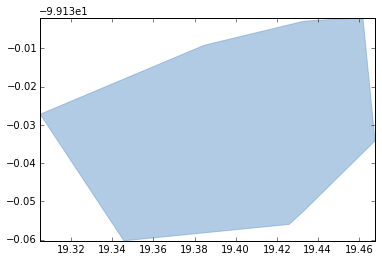

In [32]:
ny_df = train_df1[train_df1['cluster_label'] == large_clusters[0]]

from shapely.geometry import MultiPoint
from descartes.patch import PolygonPatch

coord_subcluster0 = ny_df[['lat','longitude']].values
#coord_subcluster1 = ny_df[ny_df['cluster_label_2']==1][['lat','longitude']].values


cvh0 = MultiPoint(coord_subcluster0).convex_hull
#cvh1 = MultiPoint(coord_subcluster1).convex_hull

fig = plt.figure()
ax = fig.add_subplot(111)
patch1 = PolygonPatch(cvh0, facecolor='#6699cc', edgecolor='#6699cc', alpha=0.5, zorder=2)

xrange1 = [min(coord_subcluster0[:,0]), max(coord_subcluster0[:,0])]
yrange1 = [min(coord_subcluster0[:,1]), max(coord_subcluster0[:,1])]
ax.set_xlim(*xrange1)
#ax.set_xticks(range(*xrange) + [xrange[-1]])
ax.set_ylim(*yrange1)
#ax.set_yticks(range(*yrange) + [yrange[-1]])

ax.add_patch(patch1)



In [10]:
import folium
map_osm = folium.Map(location=[0,0],
                    tiles='OpenStreetMap',
                    zoom_start = 13)

In [12]:
colors = [
    '#d73027',
    '#f46d43',
    '#fdae61',
    '#fee090',
    '#e0f3f8',
    '#abd9e9',
    '#74add1',
    '#4575b4'
]

In [13]:
def make_circle(lat,lon,label): 
    map_osm.circle_marker(
        location = [lat,lon],
        radius=100,
        line_color='#000000',#label,
        fill_color='#000000'#label,
    )

In [18]:
pics1 = train_df[['lat','longitude']].values

make_circle_vec = np.vectorize(make_circle)

make_circle_vec(pics1[:,0],pics1[:,1],range(0,len(train_df)))

array([None, None, None, ..., None, None, None], dtype=object)

In [21]:
from IPython.display import IFrame
map_osm.create_map(path='gsm1.html')

IFrame('gsm1.html', 700, 700)